In [1]:
import pandas as pd
import os
from os.path import join
import pylab as plt
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

generator_colors = [
    ("Petroleum Liquids", "#4B3621"),
    ("Natural Gas Internal Combustion Engine", "#808080"),
    ("Natural Gas Fired Combined Cycle",  "#B0B0B0"),
    ("Natural Gas Fired Combustion Turbine","gainsboro"),
    
    ("Landfill Gas", "peru"),
    ("Other Natural Gas", "firebrick"),
    ("Other Waste Biomass", "#8B4513"),
    ("Solar Photovoltaic", "#FFD700"),
    ("Onshore Wind Turbine", "#87CEEB"),
    ("Conventional Hydroelectric", "forestgreen"),
    ("Hydroelectric Pumped Storage", "limegreen"),
    ("Batteries", "#FF69B4"),
    ("IMPORT", "darkorchid"),
    ("Load Shed", "#FF0000"),
    ("Energy Storage", "orange"),
]

In [2]:
# Path the data directory
outputs_dir = join(os.getcwd(), '..', 'outputs', 'nom_100')
gen = pd.read_csv(join(outputs_dir, 'generation.csv'))
cap = pd.read_csv(join(outputs_dir, 'capacity.csv'))


grouped = gen.drop(columns=['gen_id', 'bus']).groupby(['fueltype']).sum()
grouped.loc["Energy Storage", :] *= -1

prices = pd.read_csv(join(outputs_dir, 'prices.csv'))

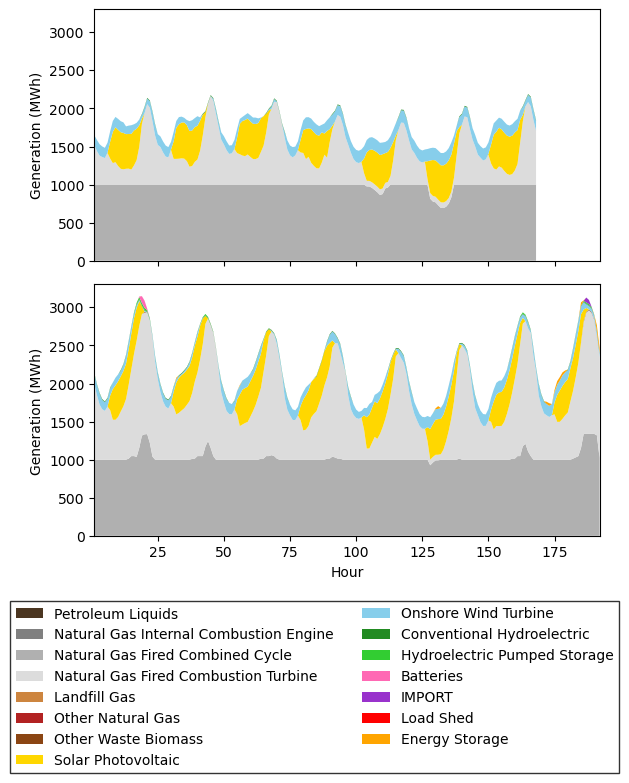

In [3]:
def generationplot(df, ax):
    df_sorted = df.loc[[i[0]for i in generator_colors]]
    y = df_sorted.to_numpy()
    ax.stackplot(range(1, len(y.T)+1), y, labels=df_sorted.index, colors=[i[1] for i in generator_colors]);
    ax.set_ylim(0, 3300)
    ax.set_ylabel("Generation (MWh)")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), sharex=True, layout='tight')

generationplot(grouped.iloc[:, 0:24*7], ax=ax1)
ax1.set_xlim(1, 24*8)
generationplot(grouped.iloc[:, 24*7:], ax=ax2)
ax2.set_xlim(1, 24*8)
ax2.set_xlabel("Hour")

handles, labels = ax1.get_legend_handles_labels()
#ax2.vlines([7*24+1],ymin=0, ymax=3300, color='k', ls='--')
lgd = fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,0), ncol=2, fancybox=False, edgecolor='k')

fig.savefig("nominal_gen_profiles.png", dpi=600, bbox_extra_artists=(lgd,), bbox_inches='tight')

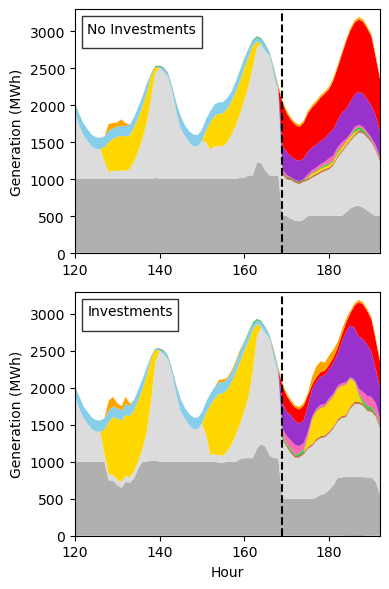

In [4]:
fig, axs = plt.subplots(2,1, figsize= (4, 6), sharey=True, layout='tight')

for ax, s in zip(axs, ['psps1_0', 'psps1_100']):
    outputs_dir = join(os.getcwd(), '..', 'outputs', s)
    df = pd.read_csv(join(outputs_dir, 'generation.csv'))
    df = df.drop(columns=['gen_id', 'bus']).groupby(['fueltype']).sum().iloc[:, 24*7:]
    df.loc["Energy Storage", :] *= -1
    generationplot(df, ax)
    ax.set_xlim(24*5, 24*8)
    ax.set_ylabel("")
    ax.set_ylabel("Generation (MWh)")
    ax.vlines([7*24+1],ymin=0, ymax=3300, color='k', ls='--')

axs[0].legend([],title="No Investments", fancybox=False, edgecolor='k',)
axs[1].legend([],title="Investments", fancybox=False, edgecolor='k',)
axs[1].set_xlabel("Hour")
plt.savefig("psps1.png", dpi=600)

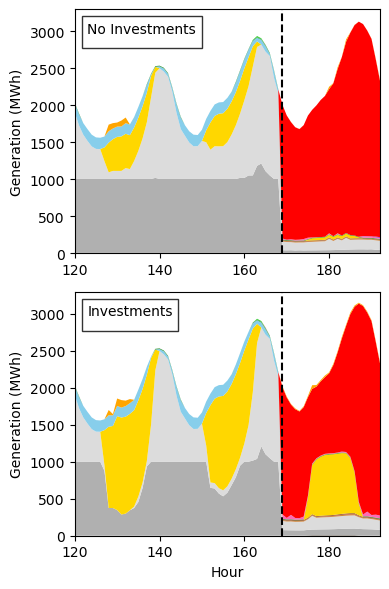

In [5]:
fig, axs = plt.subplots(2,1, figsize= (4, 6), sharey=True, layout='tight')

for ax, s in zip(axs, ['psps2_0', 'psps2_100']):
    outputs_dir = join(os.getcwd(), '..', 'outputs', s)
    df = pd.read_csv(join(outputs_dir, 'generation.csv'))
    df = df.drop(columns=['gen_id', 'bus']).groupby(['fueltype']).sum().iloc[:, 24*7:]
    df.loc["Energy Storage", :] *= -1
    generationplot(df, ax)
    ax.set_xlim(24*5, 24*8)
    ax.set_ylabel("")
    ax.set_ylabel("Generation (MWh)")
    ax.vlines([7*24+1],ymin=0, ymax=3300, color='k', ls='--')

axs[0].legend([],title="No Investments", fancybox=False, edgecolor='k',)
axs[1].legend([],title="Investments", fancybox=False, edgecolor='k',)
axs[1].set_xlabel("Hour")
plt.savefig("psps2.png", dpi=600)

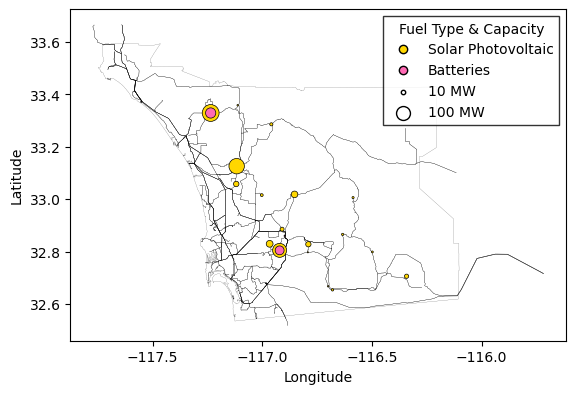

In [6]:
### GEO PLOT OF GENS ###

# Read data
inputs_dir = join(os.getcwd(), '..', 'inputs')
outputs_dir = join(os.getcwd(), '..', 'outputs', 'psps1_100')

cap = pd.read_csv(join(outputs_dir, 'capacity.csv'))

df = gpd.read_file(join(inputs_dir, 'lines.csv'))
df['geometry'] = df['geometry'].apply(wkt.loads)
lines = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")

df = gpd.read_file(join(inputs_dir, 'buses.csv'))
buses = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.lon, df.lat), crs="EPSG:4326"
)
buses.bus = buses.bus.astype(int)

cap = buses.set_index('bus').join(cap[cap['capacity'] != 0].set_index('bus'))

ious = gpd.read_file(join(os.getcwd(), '..','preprocessing', 'data', 'iou.geojson'))
sdge = ious[ious['Acronym'] == 'SDG&E'][['geometry']]

## Plot lines and gens ##

ax = lines.plot(lw=0.15, zorder=0, color='k')



# Plot fuel types with capacity-based marker size
fuel_colors = {
    'Solar Photovoltaic': '#FFD700',
    'Batteries': '#FF69B4'
}

for fuel, color in fuel_colors.items():
    cap[cap['fueltype'] == fuel].plot(
        ax=ax,
        markersize=cap[cap['fueltype'] == fuel]['capacity'],
        color=color,
        lw=0.5,
        edgecolor='k'
    )

sdge.plot(ax=ax, facecolor='none', edgecolor='k', lw=0.1)
plt.xlabel("Longitude")
plt.ylabel("Latitude")


fuel_handles = [
    mlines.Line2D([], [], marker='o', linestyle='None',
                  markerfacecolor=color, markeredgecolor='k', label=fuel)
    for fuel, color in fuel_colors.items()
]

size_examples = [10, 100]
size_handles = [
    plt.scatter([], [], s=size, color='white', edgecolors='k', label=f'{size} MW')
    for size in size_examples
]

combined_handles = fuel_handles + size_handles
combined_labels = [h.get_label() for h in combined_handles]

ax.legend(combined_handles, combined_labels, title='Fuel Type & Capacity', fancybox=False, edgecolor='k',  loc='upper right')
#plt.savefig("system_cap.png", dpi=600)